# 1. torch.ao的量化

- 我们使用的是torch2.8.0的量化实现，在2.9.1开始逐步把torch中的量化实现，迁移到torchao框架中，并集成了第三方的稀疏矩阵量化技术。新的torchao的封装还不是特别稳定，同时transformers框架中使用的也是torch中的量化模块，所以我们选在使用torch2.8.0的量化实现。

## 1.1. 理解量化

- **量化**是指在低于浮点精度的位宽上执行计算和存储张量的技术。
    - 量化模型在降低精度的张量上执行部分或全部运算，而非使用全精度（浮点）值。这使得模型表示更加紧凑，并能在许多硬件平台上使用高性能的向量化运算。
    - 与典型的FP32模型相比，PyTorch支持INT8量化，可使模型大小缩减4倍，内存带宽需求也减少4倍。硬件对INT8计算的支持通常比FP32计算快2到4倍。
    - 量化主要是一种加速推理的技术，且量化算子仅支持前向传播。

- PyTorch**支持多种量化**深度学习模型的方法。
    - 在大多数情况下，模型先以FP32格式进行训练，然后再转换为INT8格式。
    - 此外，PyTorch还支持量化感知训练，该训练使用伪量化模块在前向和后向传递中模拟量化误差。请注意，整个计算过程都是以浮点数形式进行的。在量化感知训练结束后，PyTorch会提供转换函数，将训练好的模型转换为较低精度。

- 在较低层级，PyTorch提供了一种**表示量化张量并对其进行操作**的方法。
    - 这些张量可用于直接构建以较低精度执行全部或部分计算的模型。
    - 同时，PyTorch还提供了更高级的API，这些API整合了将FP32模型转换为更低精度的典型工作流程，且能最大限度地降低精度损失。

## 1.2. torch的量化实现API

- PyTorch提供了三种不同的量化模式：
    - **Eager模式量化**：
        - Eager模式量化是一个测试版功能。用户需要手动执行算子融合，并指定量化和反量化发生的位置，此外它仅支持模块（modules）而不支持函数式操作（functionals）。
    - **FX Graph模式量化**（维护状态）：
        - FX图模式量化是PyTorch中一种自动化的量化工作流，目前是一个原型功能。由于我们已推出PyTorch 2导出量化，该模式现处于维护状态。
        - 它通过增加对函数式操作的支持以及自动化量化流程，改进了Eager模式量化，但用户可能需要重构模型以使其兼容FX图模式量化（即能够使用torch.fx进行符号跟踪）。
        - 请注意，FX图模式量化**并非适用于所有模型**，因为模型可能无法进行符号跟踪。我们会将其集成到torchvision等领域库中，用户将能够对受支持领域库中类似模型使用FX图模式量化。
        - 对于任意模型，我们会提供通用指南，但要让其实际运行，用户可能需要熟悉torch.fx，尤其是如何使模型支持符号跟踪。
    - **PyTorch 2导出量化**：
        - PyTorch 2导出量化是一种全新的全图模式量化工作流，在PyTorch 2.1中作为原型功能发布。
        - 随着PyTorch 2的推出，我们转向使用更好的完整程序捕获方案（torch.export），因为与FX图模式量化使用的torch.fx.symbolic_trace（在1.4万个模型上覆盖率为72.7%）相比，它能捕获更高比例（在1.4万个模型上覆盖率为88.8%）的模型。torch.export在某些Python结构上仍存在局限性，需要用户参与以支持导出模型中的动态性，但总体而言，它比之前的程序捕获方案有所改进。
        - PyTorch 2导出量化专为torch.export捕获的模型而构建，兼顾了建模用户和后端开发者的灵活性与生产力。其主要特性包括：
            - (1) 可编程的API，用于配置模型量化方式，能够扩展支持更多用例；
            - (2) 简化的用户体验，建模用户和后端开发者只需与单个对象（Quantizer）交互，即可表达用户对量化模型的方式和后端支持的意图；
            - (3) 可选的参考量化模型表示，能够用更接近硬件实际量化计算的整数运算来表示量化计算。
    - 建议新用户优先尝试PyTorch 2导出量化，如果效果不佳，再考虑使用Eager模式量化。

- 下表比较了Eager模式量化、FX图模式量化和PyTorch 2导出量化之间的差异。

||Eager模式量化|FX图模式量化|PyTorch 2导出量化|
|:-----:|:----|:----|:---------|
|**发布状态**|测试版|原型（维护中）|原型|  
|**算子融合**|手册|自动|自动|  
|**量化/反量化算子布局**|手册|自动|自动| 
|**量化模块**|支持|支持|支持| 
|**量化函数/Torch算子**|手册|自动|支持| 
|**定制化支持**|有限支持|完全支持|完全支持| 
|**量化模式支持**|训练后量化：静态、动态、仅权重量化<br>量化感知训练：静态|训练后量化：静态、动态、仅权重量化<br>量化感知训练：静态|由后端特定量化器定义| 
|**输入/输出模型类型**|torch.nn.Module|torch.nn.Module（可能需要进行一些重构以使模型兼容FX图模式量化）|torch.fx.GraphModule（由 torch.export 捕获）| 


- 支持三种量化类型：
    - 动态量化（权重量化，激活值以浮点数形式读取/存储，并在计算时量化）
    - 静态量化（权重量化，激活值量化，训练后需要进行校准）
    - 静态量化感知训练（权重量化，激活值量化，在训练过程中对量化数值进行建模）

- 算子的覆盖范围在动态和静态量化之间有所不同，具体如下表所示。

|量化范围|静态量化|动态量化|
|:----:|:----:|:----:|
|nn.Linear<br>nn.Conv1d/2d/3d|是<br>是|是<br>否|
|nn.LSTM<br>nn.GRU|是（通过自定义模块实现）<br>否|是<br>是|
|nn.RNNCell<br>nn.GRUCell<br>nn.LSTMCell|否<br>否<br>否|是<br>是<br>是|
|nn.EmbeddingBag|是（激活值为 fp32 格式）|是|
|nn.Embedding|是|是|
|nn.MultiheadAttention|是（通过自定义模块）|不支持|
|Activations|广泛支持|未变更，计算仍以fp32格式进行|

## 1.3. Eager模式量化（Eager Mode Quantization）

### (1) 训练后动态量化(Post Training Dynamic Quantization)

- 这是最简单的量化应用形式。它预先对权重进行量化，而在推理过程中则动态地对激活值进行量化。此方法适用于模型执行时间主要受限于从内存加载权重，而非执行矩阵乘法的场景。例如，在小批量大小情况下的LSTM和Transformer类模型。

In [109]:
import torch
import warnings
# 忽略警告
warnings.filterwarnings("ignore")
class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(3 * 32 * 32, 10 * 32 * 32)
        self.conv = torch.nn.Conv2d(10, 1, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        print("|" * 100)
        print("输入格式：", x.shape)
        x = self.fc(x)
        print("线性运算后格式：", x.shape)
        # x = x.contiguous()
        x = x.view(-1, 10, 32, 32)
        print("卷积运算前格式：", x.shape)
        x = self.conv(x)
        print("卷积运算后格式：", x.shape)
        return x


model_fp32 = M()

model_int8 = torch.ao.quantization.quantize_dynamic(model_fp32,  {torch.nn.Conv2d, torch.nn.Linear}, dtype=torch.qint8) 

input_fp32 = torch.randn(10, 3 * 32 * 32)
res = model_int8(input_fp32)
print("量化模型输出类型：", res.dtype)
print("linear模块量化前权重类型：", model_fp32.fc.weight.dtype)
print("linear模块量化后权重类型：", model_int8.fc.weight().dtype)
print("*" * 80)
print("conv模块量化前权重类型：", model_fp32.conv.weight.dtype)
from collections.abc import Callable
if isinstance(model_fp32.conv.weight, Callable):
    print("conv模块量化后权重类型：", model_int8.conv.weight().dtype)
else:
    print("conv模块量化后权重类型：", model_int8.conv.weight.dtype)
print("动态量化后的模型对象")
print(model_int8)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
输入格式： torch.Size([10, 3072])
线性运算后格式： torch.Size([10, 10240])
卷积运算前格式： torch.Size([10, 10, 32, 32])
卷积运算后格式： torch.Size([10, 1, 32, 32])
量化模型输出类型： torch.float32
linear模块量化前权重类型： torch.float32
linear模块量化后权重类型： torch.qint8
********************************************************************************
conv模块量化前权重类型： torch.float32
conv模块量化后权重类型： torch.float32
动态量化后的模型对象
M(
  (fc): DynamicQuantizedLinear(in_features=3072, out_features=10240, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (conv): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


- 代码说明：
    - 代码中使用了动态量化，动态量化对卷积运算不支持。
    - 调用`torch.ao.quantization.quantize_dynamic`函数进行动态量化操作。
    - 在代码中还需要注意一个情况：就是量化后，模块的weight不再是属性，而是函数，需要调用才能返回权重值。

### (2) 训练后静态量化（Post Training Static Quantization）

- 训练后静态量化（Post Training Static Quantization）会对模型的**权重**和**激活值**进行量化。
    - 它会在可能的情况下将激活值融合到前面的层中。
    - 该方法需要使用具有代表性的数据集进行**校准**，以确定激活值的最佳量化参数。
    - 当内存带宽和计算效率都至关重要时，通常采用训练后静态量化，CNN是典型的应用场景。

In [118]:
import torch

class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.fc = torch.nn.Linear(3 * 32 * 32, 10 * 10 * 32 * 32)
        self.relu = torch.nn.ReLU()
        self.conv = torch.nn.Conv2d(10, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.fc(x)
        x = self.relu(x)
        x = x.view(-1, 10, 32, 32)
        x = self.conv(x)
        x = self.dequant(x)
        return x

model_fp32 = M()
model_fp32.eval() # 必须将模型设置为评估模式，静态量化逻辑才能正常工作

model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('x86')  # 全局配置

# 在适用处将激活层融合到前面的层中。此操作需要根据模型架构手动完成。常见的融合包括 conv + relu 和 conv + batchnorm + relu。
model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['conv', 'relu']]) 

# 为静态量化准备模型。此步骤会在模型中插入观察器，这些观察器将在校准期间监测激活张量。
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32_fused)

# 对准备好的模型进行校准，以确定实际应用中激活值的量化参数。在校准过程中，将使用具有代表性的数据集。
input_fp32 = torch.randn(10, 3 * 32 * 32)
model_fp32_prepared(input_fp32)

# 将经过观察的模型转换为量化模型。此过程会执行以下操作：对权重进行量化；计算并存储每个激活张量将使用的缩放因子和偏置值；以及使用量化实现替换关键算子。
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)
res = model_int8(input_fp32)
print("*" * 80)
print("linear模块量化后权重类型：", model_int8.fc.weight().dtype)
print("*" * 80)
print("conv模块量化后权重类型：", model_int8.conv.weight().dtype)
print("*" * 80)
print(model_int8)
# model_int8.train()

********************************************************************************
linear模块量化后权重类型： torch.qint8
********************************************************************************
conv模块量化后权重类型： torch.qint8
********************************************************************************
M(
  (quant): Quantize(scale=tensor([0.0624]), zero_point=tensor([63]), dtype=torch.quint8)
  (fc): QuantizedLinear(in_features=3072, out_features=102400, scale=0.035630322992801666, zero_point=64, qscheme=torch.per_channel_affine)
  (relu): Identity()
  (conv): QuantizedConvReLU2d(10, 1, kernel_size=(3, 3), stride=(1, 1), scale=0.011030241847038269, zero_point=0, padding=(1, 1), bias=False)
  (dequant): DeQuantize()
)


- 代码说明：
    - 在静态量化中，线性与卷积的权重都被量化。激活函数没有权重参数。
    - 静态量化的编程模式比动态量化要复杂一些：
        - **模型定义时的处理**
            - QuantStub 将张量从浮点格式转换为量化格式。
                - 定义量化桩（存根）:`self.quant = torch.ao.quantization.QuantStub()`
                - 实现量化：`x = self.quant(x)`
            - DeQuantStub 将张量从量化格式转换为浮点格式。
                - 定义反量化桩（存根）:`self.dequant = torch.ao.quantization.DeQuantStub()`
                - 实现反量化：`x = self.dequant(x)`
        - **模型量化过程**
            - a. 需要先切换到评估模式(推理模式)：`model_fp32.eval()`
            - b. 设置模型的全局量化配置：`model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('x86')`
            - c. 将激活层融合到前面的层中：`model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['conv', 'relu']])`
            - d. 为静态量化准备模型：`model_fp32_prepared = torch.ao.quantization.prepare(model_fp32_fused)`
            - e. 对准备好的模型进行校准：`model_fp32_prepared(input_fp32)`
            - f. 将校准好的模型转换为量化模型：`model_int8 = torch.ao.quantization.convert(model_fp32_prepared)`

### (3) 静态量化的量化感知训练(Quantization Aware Training for Static Quantization)

- 量化感知训练（QAT）会在训练过程中模拟量化效应，因此相比其他量化方法，它能实现更高的精度。
    - 可以针对静态、动态或仅权重量化进行QAT。
    - 在训练期间，所有计算均以浮点格式执行，并借助fake_quant模块，通过裁剪和舍入来模拟INT8的量化效应。
    - 模型转换后，权重和激活值会被量化，并且在可能的情况下，激活层会融合到前面的层中。
    - QAT通常与CNN结合使用，相比静态量化能产生更高的精度。

In [129]:
import torch

class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.fc = torch.nn.Linear(3 * 32 * 32, 10 * 10 * 32 * 32)
        self.conv = torch.nn.Conv2d(10, 1, 3, 1, 1)
        self.bn = torch.nn.BatchNorm2d(1)
        self.relu = torch.nn.ReLU()
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.fc(x)
        x = self.relu(x)
        x = x.view(-1, 10, 32, 32)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dequant(x)
        return x

model_fp32 = M()
model_fp32.eval()

model_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['conv', 'bn', 'relu']])
# model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['fc', 'relu']])
# model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['conv', 'bn']])
# model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['conv', 'relu']])

model_fp32_fused.train()
model_fp32_prepared = torch.ao.quantization.prepare_qat(model_fp32_fused)
print("*" * 80)
print("linear模块量化后权重类型：", model_fp32_prepared.fc.weight.dtype)
print("*" * 80)
print("conv模块量化后权重类型：", model_fp32_prepared.conv.weight.dtype)
print("*" * 80)
#####################################
# 开始训练过层 
# training_loop(model_fp32_prepared)
#####################################
print("训练完成")
model_fp32_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)
print("*" * 80)
print("linear模块量化后权重类型：", model_int8.fc.weight().dtype)
print("*" * 80)
print("conv模块量化后权重类型：", model_int8.conv.weight().dtype)
print("*" * 80)
input_fp32 = torch.randn(10, 3 * 32 * 32)
res = model_int8(input_fp32)


********************************************************************************
linear模块量化后权重类型： torch.float32
********************************************************************************
conv模块量化后权重类型： torch.float32
********************************************************************************
训练完成
********************************************************************************
linear模块量化后权重类型： torch.qint8
********************************************************************************
conv模块量化后权重类型： torch.qint8
********************************************************************************


- 代码说明：
    - 训练过程中，模型是没有被量化的。其具体的过程如下：
        - a. 量化前：previous_layer_fp32 -- linear_fp32 -- activation_fp32 -- next_layer_fp32
        - b. 训练时（插入fake_quant模块）：previous_layer_fp32 -- fq -- linear_fp32 -- activation_fp32 -- fq -- next_layer_fp32
        - d. 量化后：previous_layer_int8 -- linear_with_activation_int8 -- next_layer_int8

### (4) Eager模式量化的注意事项

- Eager模式量化前需要的准备工作或者注意事项：
    - 将任何需要输出**再量化**的操作从函数形式转换为模块形式
        - 例如，使用`torch.nn.ReLU`而不是`torch.nn.functional.relu`
    - 通过在子模块上分配`qconfig`属性或指定`qconfig_mapping`，来指定模型的哪些部分需要被量化。
        - 例如，设置`model.conv1.qconfig = None`意味着`model.conv1`层将不会被量化；
        - 而设置`model.linear1.qconfig = custom_qconfig`则表示`model.linear1`的量化设置将使用`custom_qconfig`而非全局的`qconfig`。

- 对于量化激活值的静态量化技术，需要执行以下操作：
    - 指定激活值在何处被量化和反量化。这需要使用QuantStub和DeQuantStub模块来完成。
    - 使用FloatFunctional将这些需要特殊量化处理的张量运算封装成模块。例如add和cat这样的操作，它们需要特殊处理以确定输出的量化参数。
    - 融合模块：
        - 将多个操作/模块组合成一个单一的模块，以获得更高的精度和性能。这通过fuse_modules()API完成，该API接收待融合的模块列表作为参数。
        - 目前支持以下融合类型：`[Conv, Relu]`，`[Conv, BatchNorm]`，`[Conv, BatchNorm, Relu]`，`[Linear, Relu]`。

## 1.4. FX 图模式量化（原型 - 维护模式）

- 训练后量化包含多种量化类型（仅权重量化、动态量化和静态量化），其配置通过 qconfig_mapping（prepare_fx 函数的一个参数）完成。

### (1) 训练后动态/仅权重量化(post training dynamic/weight_only quantization)

In [23]:
import torch
class UserModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.quant = torch.ao.quantization.QuantStub()
        self.fc = torch.nn.Linear(3 * 32 * 32, 10 * 10 * 32 * 32)
        self.conv = torch.nn.Conv2d(10, 1, 3, 1, 1)
        self.bn = torch.nn.BatchNorm2d(1)
        self.relu = torch.nn.ReLU()
        # self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # x = self.quant(x)
        x = self.fc(x)
        x = self.relu(x)
        x = x.view(-1, 10, 32, 32)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        # x = self.dequant(x)
        return x

In [24]:
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx
import copy
from collections.abc import Callable
import warnings
# 忽略警告
warnings.filterwarnings("ignore")

# 创建模型
model_fp = UserModel()

# 深度拷贝模型
model_to_quantize = copy.deepcopy(model_fp)
model_to_quantize.eval()

qconfig_mapping = QConfigMapping().set_global(torch.ao.quantization.default_dynamic_qconfig)

# 追踪模型的示例输入
example_inputs = (torch.randn(10, 3 * 32 * 32))
# 模型准备
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)
# 进行权重量化（当仅使用动态量化或仅权重量化时，无需进行校准）
model_quantized = quantize_fx.convert_fx(model_prepared)
print(model_quantized)
print("*" * 100)
model_quantized.print_readable()
print("*" * 80)
print("linear模块量化后权重类型：", model_quantized.fc.weight().dtype)
# 注意：动态量化对conv无效

GraphModule(
  (fc): DynamicQuantizedLinearReLU(in_features=3072, out_features=102400, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (conv): ConvReLU2d(
    (0): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
)



def forward(self, x):
    fc = self.fc(x);  x = None
    view = fc.view(-1, 10, 32, 32);  fc = None
    conv = self.conv(view);  view = None
    return conv
    
# To see more debug info, please use `graph_module.print_readable()`
****************************************************************************************************
class GraphModule(torch.nn.Module):
    def forward(self, x):
         # File: C:\Program Files\Python313\Lib\site-packages\torch\fx\proxy.py:251 in create_proxy, code: user_frame_summary = CapturedTraceback.extract().summary()
        fc = self.fc(x);  x = None
        
         # File: C:\Program Files\Python313\Lib\site-packages\torch\fx\proxy.py:251 in create_proxy, code: user_frame_summary = Captured

### (2) 训练后静态量化(post training static quantization)

In [25]:
# 深度拷贝模型
model_to_quantize = copy.deepcopy(model_fp)
model_to_quantize.eval()

# 获取缺省的配置
qconfig_mapping = get_default_qconfig_mapping("qnnpack")
# 准备需要量化的模型
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)
# 校准（未显示）量化
model_quantized = quantize_fx.convert_fx(model_prepared)

print(model_quantized)
print("*" * 100)
model_quantized.print_readable()
print("*" * 80)
print("linear模块量化后权重类型：", model_quantized.fc.weight().dtype)
print("conv模块量化后权重类型：", model_quantized.conv.weight().dtype)

GraphModule(
  (fc): QuantizedLinearReLU(in_features=3072, out_features=102400, scale=1.0, zero_point=0, qscheme=torch.per_tensor_affine)
  (conv): QuantizedConvReLU2d(10, 1, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
)



def forward(self, x):
    fc_input_scale_0 = self.fc_input_scale_0
    fc_input_zero_point_0 = self.fc_input_zero_point_0
    quantize_per_tensor = torch.quantize_per_tensor(x, fc_input_scale_0, fc_input_zero_point_0, torch.quint8);  x = fc_input_scale_0 = fc_input_zero_point_0 = None
    fc = self.fc(quantize_per_tensor);  quantize_per_tensor = None
    view = fc.view(-1, 10, 32, 32);  fc = None
    conv = self.conv(view);  view = None
    dequantize_3 = conv.dequantize();  conv = None
    return dequantize_3
    
# To see more debug info, please use `graph_module.print_readable()`
****************************************************************************************************
class GraphModule(torch.nn.Module):
    def forward(s

### (3) 静态量化的量化感知训练(quantization aware training for static quantization)

In [26]:
# 深度拷贝一个模型用来做静态量化的量化感知训练
model_to_quantize = copy.deepcopy(model_fp)
# 切换到训练模式
model_to_quantize.train()

# 准备需要量化的模型
qconfig_mapping = get_default_qat_qconfig_mapping("qnnpack")
model_prepared = quantize_fx.prepare_qat_fx(model_to_quantize, qconfig_mapping, example_inputs)

#####################################
# 此处训练
# ......
#####################################
# 量化为int8，便于推理
model_quantized = quantize_fx.convert_fx(model_prepared)

print(model_quantized)
print("*" * 100)
model_quantized.print_readable()
print("*" * 80)
print("linear模块量化后权重类型：", model_quantized.fc.weight().dtype)
print("conv模块量化后权重类型：", model_quantized.conv.weight().dtype)

GraphModule(
  (fc): QuantizedLinearReLU(in_features=3072, out_features=102400, scale=1.0, zero_point=0, qscheme=torch.per_tensor_affine)
  (conv): QuantizedConvReLU2d(10, 1, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
)



def forward(self, x):
    fc_input_scale_0 = self.fc_input_scale_0
    fc_input_zero_point_0 = self.fc_input_zero_point_0
    quantize_per_tensor = torch.quantize_per_tensor(x, fc_input_scale_0, fc_input_zero_point_0, torch.quint8);  x = fc_input_scale_0 = fc_input_zero_point_0 = None
    fc = self.fc(quantize_per_tensor);  quantize_per_tensor = None
    view = fc.view(-1, 10, 32, 32);  fc = None
    conv = self.conv(view);  view = None
    dequantize_3 = conv.dequantize();  conv = None
    return dequantize_3
    
# To see more debug info, please use `graph_module.print_readable()`
****************************************************************************************************
class GraphModule(torch.nn.Module):
    def forward(s

### (4) 激活融合(fusion)

In [29]:
model_to_quantize = copy.deepcopy(model_fp)
model_to_quantize.eval()
model_fused = quantize_fx.fuse_fx(model_to_quantize)
print(model_fused)
print("*" * 100)
model_fused.print_readable()
# 没有量化操作

GraphModule(
  (fc): LinearReLU(
    (0): Linear(in_features=3072, out_features=102400, bias=True)
    (1): ReLU()
  )
  (conv): ConvReLU2d(
    (0): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
)



def forward(self, x):
    fc = self.fc(x);  x = None
    view = fc.view(-1, 10, 32, 32);  fc = None
    conv = self.conv(view);  view = None
    return conv
    
# To see more debug info, please use `graph_module.print_readable()`
****************************************************************************************************
class GraphModule(torch.nn.Module):
    def forward(self, x):
        # No stacktrace found for following nodes
        fc = self.fc(x);  x = None
        view = fc.view(-1, 10, 32, 32);  fc = None
        conv = self.conv(view);  view = None
        return conv
        


'class GraphModule(torch.nn.Module):\n    def forward(self, x):\n        # No stacktrace found for following nodes\n        fc = self.fc(x);  x = None\n        view = fc.view(-1, 10, 32, 32);  fc = None\n        conv = self.conv(view);  view = None\n        return conv\n        '

## 1.5. PyTorch 2导出量化(PyTorch 2 Export Quantization)

### (1) PyTorch 2 导出训练后量化(PyTorch 2 Export Post Training Quantization)

- 基于torch.export.export以图模式执行训练后静态量化。
    - 与FX图模式量化相比，此量化流程预计将显著提高模型覆盖率（在14K个模型上达到 88%），具备更好的可编程性，并简化用户体验。
    - 使用torch.export.export导出是使用此流程的先决条件。

- 采用量化器的量化2.0(PyTorch 2导出量化)高级架构可能如下所示：
    - 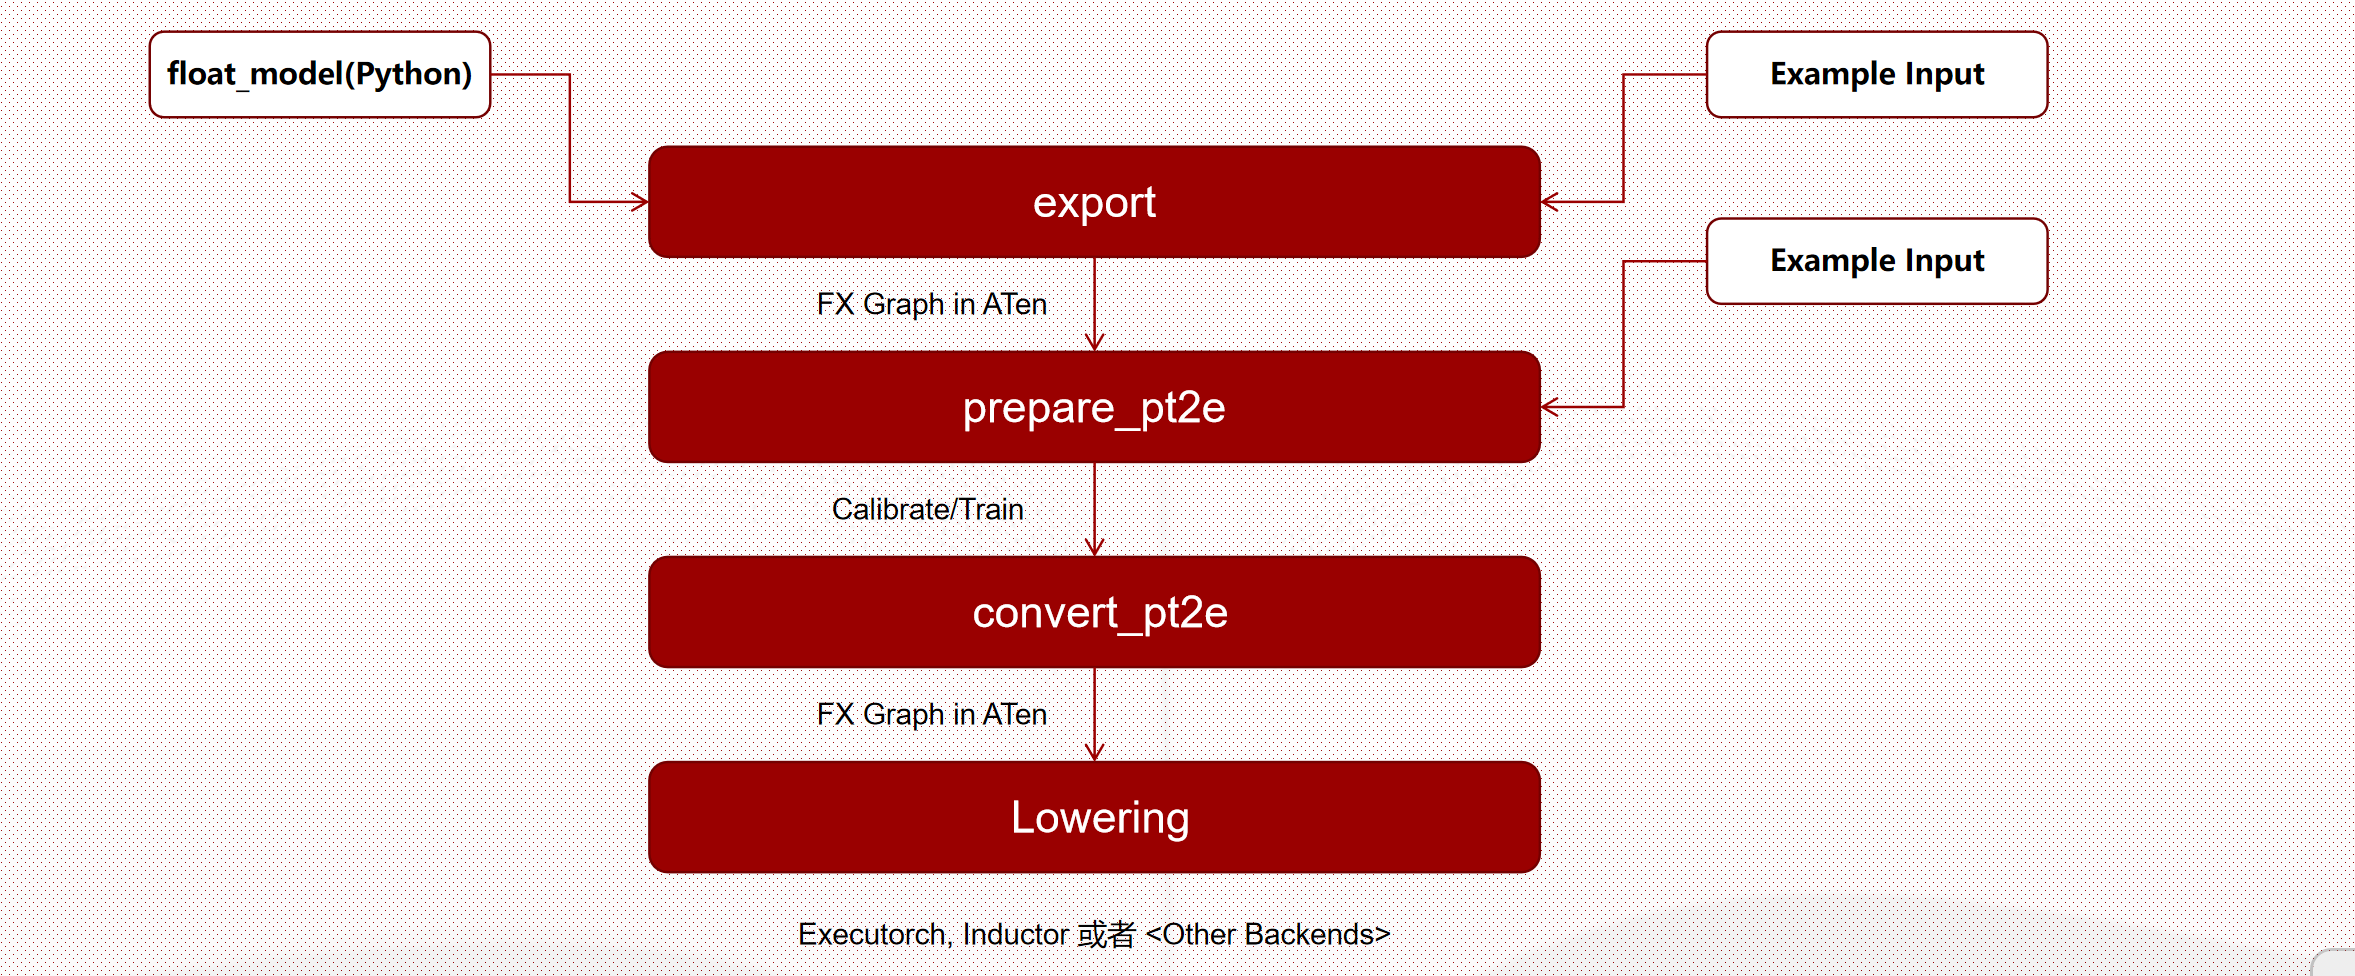

In [20]:
import warnings
# 忽略警告
warnings.filterwarnings("ignore")

import torch
# 定义模型
class UserModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.quant = torch.ao.quantization.QuantStub()
        self.fc = torch.nn.Linear(3 * 32 * 32, 10 * 10 * 32 * 32)
        self.conv = torch.nn.Conv2d(10, 1, 3, 1, 1)
        self.bn = torch.nn.BatchNorm2d(1)
        self.relu = torch.nn.ReLU()
        # self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # x = self.quant(x)
        x = self.fc(x)
        x = self.relu(x)
        x = x.view(-1, 10, 32, 32)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        # x = self.dequant(x)
        return x

# 模拟输入数据
example_inputs = (torch.randn(10, 3 * 32 * 32), )
m = UserModel()  # 训练好的模型
m.eval()

# 第一步：程序捕获（torch2.6以上版本支持）
m = torch.export.export(m, example_inputs).module()  # 返回一个包含aten算子的模型

# 第二步：量化
from torch.ao.quantization.quantize_pt2e import (
  prepare_pt2e,
  convert_pt2e,
)

# 可以使用executorch框架 ：`pip install executorch`，安装executorch需要torch 2.10版本
# from executorch.backends.xnnpack.quantizer.xnnpack_quantizer import (
#   get_symmetric_quantization_config,
#   XNNPACKQuantizer,
# )
# 这里是使用torch 2.8版本中的模块。
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)
# 后端开发者将编写自己的量化器，并公开方法供用户表达他们对模型量化的需求（我们使用的是torch提供的）
quantizer = XNNPACKQuantizer().set_global(get_symmetric_quantization_config())
# 准备需要量化的模型
m = prepare_pt2e(m, quantizer)

# 还可以添加校准（省略）

# 进行量化操作
m = convert_pt2e(m) # 返回一个量化的模型（使用 aten 算子执行整数计算。）
print(m)
print("*" * 100)
m.print_readable()
print("*" * 80)
# print("linear模块量化后权重类型：", list(m.fc.parameters())[0].dtype)
# print("conv模块量化后权重类型：", list(m.conv.parameters())[0].dtype)

GraphModule(
  (fc): Module()
  (conv): Module()
)



def forward(self, x):
    x, = fx_pytree.tree_flatten_spec(([x], {}), self._in_spec)
    _frozen_param0 = self._frozen_param0
    dequantize_per_tensor_default = torch.ops.quantized_decomposed.dequantize_per_tensor.default(_frozen_param0, 1.0, 0, -127, 127, torch.int8);  _frozen_param0 = None
    fc_bias = self.fc.bias
    _frozen_param1 = self._frozen_param1
    dequantize_per_tensor_default_1 = torch.ops.quantized_decomposed.dequantize_per_tensor.default(_frozen_param1, 1.0, 0, -127, 127, torch.int8);  _frozen_param1 = None
    conv_bias = self.conv.bias
    quantize_per_tensor_default_2 = torch.ops.quantized_decomposed.quantize_per_tensor.default(x, 1.0, 0, -128, 127, torch.int8);  x = None
    dequantize_per_tensor_default_2 = torch.ops.quantized_decomposed.dequantize_per_tensor.default(quantize_per_tensor_default_2, 1.0, 0, -128, 127, torch.int8);  quantize_per_tensor_default_2 = None
    linear = torch.ops.aten.linear.default(

- 代码说明：
    - 在torch2.10版本后，已经迁移到torchao（可以根据torch版本，安装对应版本）
    - 更加详细的资料，可以参考：`https://docs.pytorch.org/ao/main/pt2e_quantization/pt2e_quant_ptq.html`

### (2) PyTorch 2 导出量化感知训练 (QAT：PyTorch 2 Export Quantization-Aware Training)

- 基于 torch.export.export 在图模式下执行量化感知训练 (QAT)

In [19]:
import torch
from torch.ao.quantization.quantize_pt2e import (
    convert_pt2e,
    prepare_pt2e,
    prepare_qat_pt2e,
)
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)

# 定义模型
class UserModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.quant = torch.ao.quantization.QuantStub()
        self.fc = torch.nn.Linear(3 * 32 * 32, 10 * 10 * 32 * 32)
        self.conv = torch.nn.Conv2d(10, 1, 3, 1, 1)
        # self.bn = torch.nn.BatchNorm2d(1)
        self.relu = torch.nn.ReLU()
        # self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # x = self.quant(x)
        x = self.fc(x)
        x = self.relu(x)
        x = x.view(-1, 10, 32, 32)
        x = self.conv(x)
        # x = self.bn(x)
        x = self.relu(x)
        # x = self.dequant(x)
        return x

# 模拟输入数据
example_inputs = (torch.randn(10, 3 * 32 * 32), )

m = UserModel()

# 第一步. 程序捕获（导出模型）
m = torch.export.export(m, example_inputs).module()

# 第二步：量化感知训练
quantizer = XNNPACKQuantizer().set_global(get_symmetric_quantization_config())
m = prepare_qat_pt2e(m, quantizer)
#####################################
# 模型训练（省略）
#####################################

# 量化模型（整数计算）
m = convert_pt2e(m)
print(m)
print("*" * 100)
m.print_readable()
print("*" * 80)
# 将量化模型切换到评估模式，等同于 m.eval()
torch.ao.quantization.move_exported_model_to_eval(m)

GraphModule(
  (fc): Module()
  (conv): Module()
)



def forward(self, x):
    x, = fx_pytree.tree_flatten_spec(([x], {}), self._in_spec)
    _frozen_param0 = self._frozen_param0
    dequantize_per_tensor_default = torch.ops.quantized_decomposed.dequantize_per_tensor.default(_frozen_param0, 1.0, 0, -127, 127, torch.int8);  _frozen_param0 = None
    fc_bias = self.fc.bias
    _frozen_param1 = self._frozen_param1
    dequantize_per_tensor_default_1 = torch.ops.quantized_decomposed.dequantize_per_tensor.default(_frozen_param1, 1.0, 0, -127, 127, torch.int8);  _frozen_param1 = None
    conv_bias = self.conv.bias
    quantize_per_tensor_default_2 = torch.ops.quantized_decomposed.quantize_per_tensor.default(x, 1.0, 0, -128, 127, torch.int8);  x = None
    dequantize_per_tensor_default_2 = torch.ops.quantized_decomposed.dequantize_per_tensor.default(quantize_per_tensor_default_2, 1.0, 0, -128, 127, torch.int8);  quantize_per_tensor_default_2 = None
    linear = torch.ops.aten.linear.default(

GraphModule(
  (fc): Module()
  (conv): Module()
)

- 代码说明：
    - 导出量化感知训练中，对BatchNorm2d操作不支持。
    - 导出量化感知训练中，调用prepare_qat_pt2e完成模型准备。

----

## 1.6. torch.ao的API说明

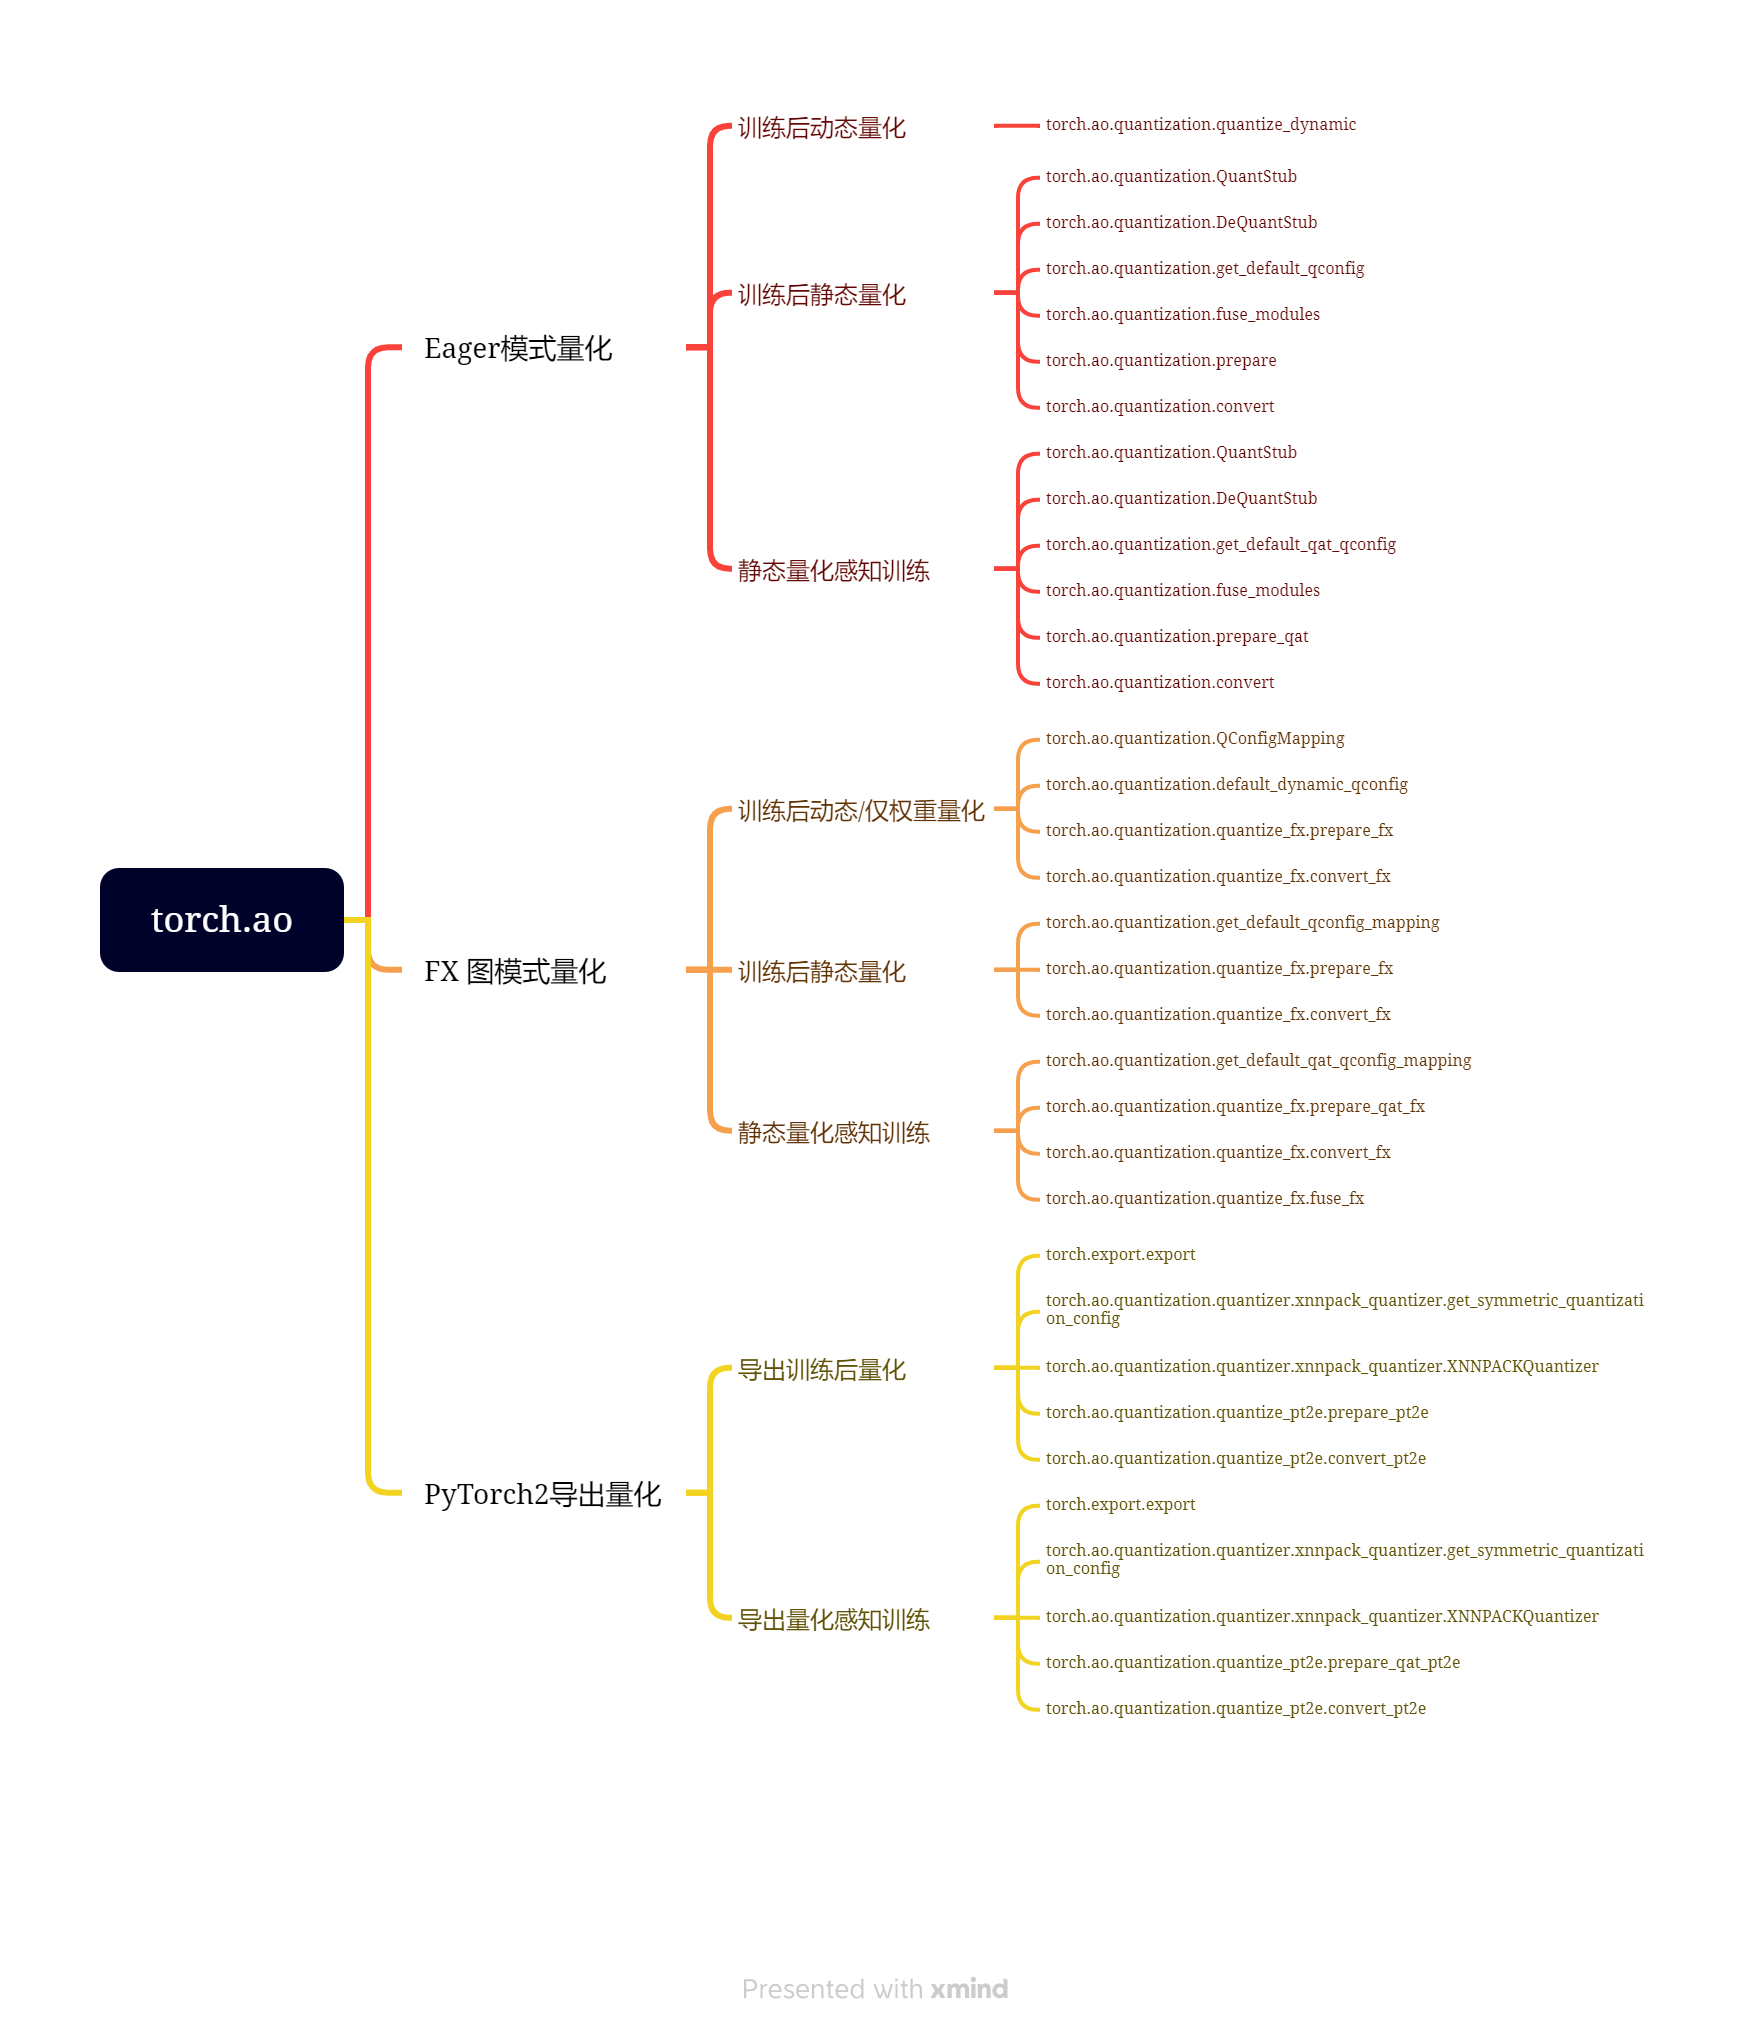